# PREPROCESSING
--------------
--------------
--------------

&nbsp;

This notebook is to test out preprocessing methods to see if accuracy can be increased. It should be merged with the dataPrep notebook after processing type is selected

In [1]:
# import pywt
import scipy
from scipy.signal import hilbert, savgol_filter, wavelets, periodogram
import pandas as pd
import numpy as np
# import meegkit
import nolds
# import emd
# import ica # standalone ICA package that utilizes INFOMAX, Sejnowski et al
# from mne.preprocessing import infomax
from sklearn.decomposition import FastICA

In [ ]:
cols = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
emotiv = pd.read_csv('../../fulldata/EP1.txt', delimiter='\t', names=cols)

In [ ]:
# using the most correlated channel for a test column to .explode. signal processing in full timeseries format seems like a good idea
fefF4 = emotiv[(emotiv['channel'] == 'F4')]
fefF4['data'] = fefF4['data'].apply(lambda x: x.split(','))
fefF4Exp = fefF4.explode('data')
fefF4Exp['data'] =  fefF4Exp['data'].astype(float)

In [2]:
testfefF4 = pd.read_csv('../data/fefF4Exp.csv', delimiter=',')

In [10]:
testfefF4 = testfefF4.drop('id', axis=1)

<AxesSubplot:>

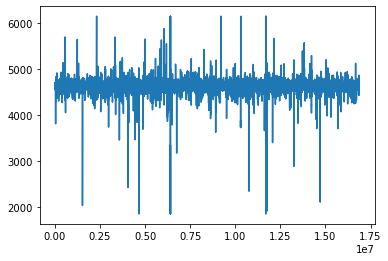

In [13]:
testfefF4['data'].plot()

In [27]:
testfefF4.head(900)

,event,device,channel,code,size,data
0,67635,EP,F4,6,260,4682.051282
1,67635,EP,F4,6,260,4667.179487
2,67635,EP,F4,6,260,4662.051282
3,67635,EP,F4,6,260,4669.230769
4,67635,EP,F4,6,260,4676.410256
...,...,...,...,...,...,...
895,67638,EP,F4,9,264,4651.794871
896,67638,EP,F4,9,264,4648.717948
897,67638,EP,F4,9,264,4652.820512
898,67638,EP,F4,9,264,4652.820512


In [ ]:
testfefF4.gr

## Savitzky-Golay Filter

![Gif of how the filter smoothly approximates the curve at discrete time steps](https://upload.wikimedia.org/wikipedia/commons/8/89/Lissage_sg3_anim.gif)

"The idea of Savitzky-Golay filters is simple – for each sample in the filtered sequence, take its direct neighborhood of N neighbors and fit a polynomial to it. Then just evaluate the polynomial at its center (and the center of the neighborhood), point 0, and continue with the next neighborhood. "


-- https://bartwronski.com/2021/11/03/study-of-smoothing-filters-savitzky-golay-filters/

In [4]:
fefF4Exp['SGFdata'] = savgol_filter(fefF4Exp['data'], 10001, 1 )    

In [6]:
fefF4Exp[['code', 'data', 'SGFdata']].corr()

,code,data,SGFdata
code,1.000000,0.007567,0.009726
data,0.007567,1.000000,0.486024
SGFdata,0.009726,0.486024,1.000000


Results:

5, 2 → +0.000004 increase (at least it's going in the right direction)

5, 4 → 0 (higher order polynoms are too close to the noisy data)

7, 1 → +0.000030 (see?)

29, 1 →+0.000090

101, 1→+0.000170

1011,1→+0.002100

10111,1→+0.002200

In [ ]:
# does the correlation stay after grouping by mean per event?
.groupby('event').mean()

In [1]:
# pywt.cwt([row.split() for row in emotiv['data']], ) # this one returns array of coefs and an array of freqs 
# testCWT = scipy.signal.wavelets.cwt(dataColFlatFloat, wavelet=scipy.signal.ricker, widths=np.arange(1, 31) ) # this one just returns an NxM matrix, may lose info but could be easier to work with

### ICA (infomax)

In [22]:
# ica.infomax1(fefF4Exp['data'])
#"MemoryError: Unable to allocate 2.02 PiB for an array with shape (16877097, 16877097) and data type float64"

In [23]:
# ica.ica1(fefF4Exp['data'], ncomp=1, verbose=True) # any way to make this work on only a series?
# ValueError: No axis named 1 for object type Series

In [57]:
# fefF4Exp['ICAdata'] = infomax(fefF4Exp['data'], verbose=True
fICA = FastICA(5, whiten=True)

fefF4Exp['ICAdata'] = fICA.fit_transform(fefF4Exp['data'].to_numpy().reshape(-1, 1))

#could try just a fit and making different columns out of each component, if that's possible

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(


In [58]:
fefF4Exp[['data', 'ICAdata']]

,data,ICAdata
11,4682.051282,0.000161
11,4667.179487,0.000108
11,4662.051282,0.000090
11,4669.230769,0.000116
11,4676.410256,0.000141
...,...,...
910473,4587.692307,-0.000175
910473,4592.307692,-0.000158
910473,4586.153846,-0.000180
910473,4589.230769,-0.000169


In [59]:
fefF4Exp.corr()

,id,event,code,size,data,ICAdata
id,1.000000,1.000000,-0.009449,-0.006898,-0.011739,-0.011739
event,1.000000,1.000000,-0.009449,-0.006898,-0.011739,-0.011739
code,-0.009449,-0.009449,1.000000,0.006296,0.007567,0.007567
size,-0.006898,-0.006898,0.006296,1.000000,0.004493,0.004493
data,-0.011739,-0.011739,0.007567,0.004493,1.000000,1.000000
ICAdata,-0.011739,-0.011739,0.007567,0.004493,1.000000,1.000000


This doesn't change the correlation at all, but would it be a helpful feature for a CNN classifier?

### Discrete Source Separation

### Isomap/other manifold reduction

### Wavelet Transform
![Gif showing a wavelet traveling along a curve over and over changing slightly in size, it's path is plotted next to it](https://upload.wikimedia.org/wikipedia/commons/9/95/Continuous_wavelet_transform.gif)
(continuous shown here, probably going to have to use discrete)

In [79]:
# fefF4Exp['CWTdata'] = wavelets.cwt(fefF4Exp['data'], wavelet=scipy.signal.ricker, widths=np.arange(1, 16877097) ) 
# MemoryError: Unable to allocate 2.02 PiB for an array with shape (16877096, 16877097) and data type float64
# lmao guess not

# fefF4Exp['CWTdata'] = pywt.cwt(fefF4Exp['data'], scales=np.arange(1, 31), wavelet='bior6.8' )
# fefF4Exp['DWTdata'] = pywt.wavedec(fefF4Exp['data'], wavelet='sym2' )

# fefF4Exp['SWTdata'] = pywt.swt(fefF4Exp['data'].iloc[:-1], wavelet='bior6.8' )

# keep getting errors like 
# ValueError: Length of values (3) does not match length of index (16877097)
# but the values number changes by type of wavelet and transform.. so it's hard to tell where that's coming from

### Hilbert Transform

Wavelet transform is not ideal for neural data because it relies on windows of different sizes (see Mike X Cohen's youtube channel). Hilbert transform might be the better option
provide unique analytic signal from real value data, so you can calculate instantaneous properties of your data" -EstherExplains v=dy4OeAYqSqM 


HT gives amplitude and phase, so "energy-frequency-time distribution"
> 1, Fourier Transform real valued signal
> 2. Set Fourier coefficients of negative frequencies to zero so they cannot cancel out the imaginary part related to the positive frequencies during the inverse FT
> 3. Double the amplitude related to positive frequencies for energy conservation
> 4. Inverse Fourier transform to obtain the analytic (complex signal)


```
Returns xandarray Analytic signal of x, of each 1-D array along axis

In [6]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            15Gi        11Gi       735Mi       244Mi       2.9Gi       3.1Gi
Swap:          976Mi       0.0Ki       976Mi


In [80]:
# fefF4Exp['Hilbdata'] = hilbert(fefF4Exp['data']) 

In [82]:
# fefF4Exp.corr()

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/managers.py:893: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr


,id,event,code,size,data,SGFdata,Hilbdata
id,1.000000,1.000000,-0.009449,-0.006898,-0.011739,-0.027377,-0.011739
event,1.000000,1.000000,-0.009449,-0.006898,-0.011739,-0.027377,-0.011739
code,-0.009449,-0.009449,1.000000,0.006296,0.007567,0.009786,0.007567
size,-0.006898,-0.006898,0.006296,1.000000,0.004493,0.004751,0.004493
data,-0.011739,-0.011739,0.007567,0.004493,1.000000,0.482972,1.000000
SGFdata,-0.027377,-0.027377,0.009786,0.004751,0.482972,1.000000,0.482972
Hilbdata,-0.011739,-0.011739,0.007567,0.004493,1.000000,0.482972,1.000000


Looks like the Hilbert transform doesn't change the correlation at all. Maybe the Hilbert-Huang transform, which not only gives the envelope and the frequency info, but transforms it to the norm of the envelope (I think). But for this I would need a different package. The Empirical Mode Decomposition package emd seems to have it

### Hilbert-Huang Transform

In [4]:
sampleRate = fefF4Exp['data'].diff().median()

In [5]:
imf = emd.sift.mask_sift(fefF4Exp['data'], max_imfs=3) # Intrinsic Mode Function
IPdata, IFdata, IAdata = emd.spectra.frequency_transform(imf, sampleRate, 'nht') # Instantaneous Phase, Instantaneous Frequency, Instantaneous Amplitude
emd.spectra.hilberthuang() # maybe above is all you need^

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/emd/support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


In [8]:
# fefF4Exp['IPdata'] = IPdata # these are 3D
# fefF4Exp['IFdata'] = IFdata
# fefF4Exp['IAdata'] = IAdata # don't actually need amplitude because the 

array([[1.61463711, 1.57079633, 0.59287713],
       [2.93175836, 1.58118111, 0.59287713],
       [4.0942524 , 1.63644521, 0.59287713],
       ...,
       [4.34524491, 0.81421972, 5.76970909],
       [4.34524491, 0.81421972, 5.76970909],
       [4.34524491, 0.81421972, 5.76970909]])

### Correlation Dimension & Lyapunov Exponents

In [ ]:
nolds.corr_dim(fefF4Exp['data'], emb_dim=1)

### Power Spectrum Decomposition

In [12]:
# Freqdata, PSDdata = periodogram(fefF4Exp['data']) # crashes kernel

In [18]:
# len(Freqdata), len(PSDdata)
# Freqdata = pd.Series(Freqdata)
# PSDdata = pd.Series(PSDdata)

In [ ]:
# psdInterim = pd.concat([Freqdata, PSDdata], axis=1)
# psdInterim = psdInterim.set_axis(['Freqdata', 'PSDdata'], axis=1)

# fefF4Exp = pd.concat([fefF4Exp, psdInterim], axis=1) 

## Creating filtered data csv files for all channels

In [2]:
fefF3Exp = pd.read_csv('../data/fefF3Exp.csv', delimiter=',')
fefF4Exp = pd.read_csv('../data/fefF4Exp.csv', delimiter=',')
fefF7Exp = pd.read_csv('../data/fefF7Exp.csv', delimiter=',')
fefF8Exp = pd.read_csv('../data/fefF8Exp.csv', delimiter=',')
motFC5Exp = pd.read_csv('../data/motFC5Exp.csv', delimiter=',')
motFC6Exp = pd.read_csv('../data/motFC6Exp.csv', delimiter=',')
occ0Exp = pd.read_csv('../data/occ0Exp.csv', delimiter=',')
occ1Exp = pd.read_csv('../data/occ1Exp.csv', delimiter=',')
parP7Exp = pd.read_csv('../data/parP7Exp.csv', delimiter=',')
parP8Exp = pd.read_csv('../data/parP8Exp.csv', delimiter=',')
pfcAF3Exp = pd.read_csv('../data/pfcAF3Exp.csv', delimiter=',')
pfcAF4Exp = pd.read_csv('../data/pfcAF4Exp.csv', delimiter=',')
temT7Exp = pd.read_csv('../data/temT7Exp.csv', delimiter=',')
temT8Exp = pd.read_csv('../data/temT8Exp.csv', delimiter=',')

In [3]:
fICA = FastICA(n_components=5, whiten=True)

fefF3Exp['ICAdata'] = fICA.fit_transform(fefF3Exp['data'].to_numpy().reshape(-1, 1))
fefF4Exp['ICAdata'] = fICA.fit_transform(fefF4Exp['data'].to_numpy().reshape(-1, 1))
fefF7Exp['ICAdata'] = fICA.fit_transform(fefF7Exp['data'].to_numpy().reshape(-1, 1))
fefF8Exp['ICAdata'] = fICA.fit_transform(fefF8Exp['data'].to_numpy().reshape(-1, 1))
motFC5Exp['ICAdata'] = fICA.fit_transform(motFC5Exp['data'].to_numpy().reshape(-1, 1))
motFC6Exp['ICAdata'] = fICA.fit_transform(motFC6Exp['data'].to_numpy().reshape(-1, 1))
occ0Exp['ICAdata'] = fICA.fit_transform(occ0Exp['data'].to_numpy().reshape(-1, 1))
occ1Exp['ICAdata'] = fICA.fit_transform(occ1Exp['data'].to_numpy().reshape(-1, 1))
parP7Exp['ICAdata'] = fICA.fit_transform(parP7Exp['data'].to_numpy().reshape(-1, 1))
parP8Exp['ICAdata'] = fICA.fit_transform(parP8Exp['data'].to_numpy().reshape(-1, 1))
pfcAF3Exp['ICAdata'] = fICA.fit_transform(pfcAF3Exp['data'].to_numpy().reshape(-1, 1))
pfcAF4Exp['ICAdata'] = fICA.fit_transform(pfcAF4Exp['data'].to_numpy().reshape(-1, 1))
temT7Exp['ICAdata'] = fICA.fit_transform(temT7Exp['data'].to_numpy().reshape(-1, 1))
temT8Exp['ICAdata'] = fICA.fit_transform(temT8Exp['data'].to_numpy().reshape(-1, 1))

/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
/home/h/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_

In [40]:
# fefF3Exp['SGFdata'] = savgol_filter(fefF3Exp['data'], 10001, 1 ) 
# fefF4Exp['SGFdata'] = savgol_filter(fefF4Exp['data'], 10001, 1 ) 
# fefF7Exp['SGFdata'] = savgol_filter(fefF7Exp['data'], 10001, 1 )
# fefF8Exp['SGFdata'] = savgol_filter(fefF8Exp['data'], 10001, 1 )
# motFC5Exp['SGFdata'] = savgol_filter(motFC5Exp['data'], 10001, 1 )
# motFC6Exp['SGFdata'] = savgol_filter(motFC6Exp['data'], 10001, 1 )
# occ0Exp['SGFdata'] = savgol_filter(occ0Exp['data'], 10001, 1 )
# occ1Exp['SGFdata'] = savgol_filter(occ1Exp['data'], 10001, 1 )
# parP7Exp['SGFdata'] = savgol_filter(parP7Exp['data'], 10001, 1 )
# parP8Exp['SGFdata'] = savgol_filter(parP8Exp['data'], 10001, 1 )
# pfcAF3Exp['SGFdata'] = savgol_filter(pfcAF3Exp['data'], 10001, 1 ) 
# pfcAF4Exp['SGFdata'] = savgol_filter(pfcAF4Exp['data'], 10001, 1 )
# temT7Exp['SGFdata'] = savgol_filter(temT7Exp['data'], 10001, 1 ) 
['SGFdata'] = savgol_filter(temT8Exp['data'], 10001, 1 )

In [12]:
fefF3Exp.to_csv('../data/fefF3Proc.csv', sep=',')
fefF4Exp.to_csv('../data/fefF4Proc.csv', sep=',')
fefF7Exp.to_csv('../data/fefF7Proc.csv', sep=',')
fefF8Exp.to_csv('../data/fefF8Proc.csv', sep=',')

In [13]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            15Gi        12Gi       177Mi       132Mi       2.4Gi       2.2Gi
Swap:          976Mi       911Mi        65Mi


In [15]:
import gc

del fefF3Exp
del fefF4Exp
del fefF7Exp
del fefF8Exp

gc.collect()

1050

In [16]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            15Gi       9.9Gi       3.2Gi       134Mi       2.4Gi       5.2Gi
Swap:          976Mi       916Mi        60Mi


In [27]:
motFC5Exp.to_csv('../data/motFC5Proc.csv', sep=',')
motFC6Exp.to_csv('../data/motFC6Proc.csv', sep=',')
occ0Exp.to_csv('../data/occ0ExpProc.csv', sep=',')
occ1Exp.to_csv('../data/occ1ExpProc.csv', sep=',')

del motFC5Exp
del motFC6Exp
del occ0Exp
del occ1Exp

gc.collect()

2755

In [28]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            15Gi       9.1Gi       2.2Gi       323Mi       4.2Gi       5.8Gi
Swap:          976Mi       768Mi       208Mi


In [31]:
parP7Exp.to_csv('../data/parP7Proc.csv', sep=',')
parP8Exp.to_csv('../data/parP8Proc.csv', sep=',')
pfcAF3Exp.to_csv('../data/pfcAF3Proc.csv', sep=',')

del parP7Exp
del parP8Exp
del pfcAF3Exp
s
gc.collect()

142

In [42]:
pfcAF4Exp.to_csv('../data/pfcAF4Proc.csv', sep=',')
temT7Exp.to_csv('../data/temT7Proc.csv', sep=',')
temT8Exp.to_csv('../data/temT8Proc.csv', sep=',')

del pfcAF4Exp
del temT7Exp
del temT8Exp

gc.collect()

169